### Imports

In [129]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import array as array
from scipy.stats import pearsonr
%matplotlib inline
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [130]:
### Function

In [131]:
def wAvrgAggr(df, cName):
    totalW = 0.0
    totVal = 0.0
    for value, weight in zip(df[cName], df['TotalPop']):
        totVal += float(value) * float(weight)
        totalW += weight
    return totVal/totalW

def sumAggregation(df, cName):
    return df[cName].sum()

def weighted_median(df, val):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted['TotalPop'].cumsum()
    cutoff = df_sorted['TotalPop'].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

### Data Loading

In [132]:
demographics=pd.read_csv("data/income/demographic.csv")
c_results=pd.read_csv("data/output/countyData.csv")
s_results=pd.read_csv("data/output/stateData.csv")

### Data Cleaning - Demographics

In [133]:
#Porto Rico doesnt vote
demographics.drop(demographics[demographics.State=='Puerto Rico'].index, inplace=True)

#Drop Columns
demographics.drop(['CountyId','IncomeErr','IncomePerCapErr'], axis=1, inplace=True)

#General Data adjustment for mapping
demographics['County'] = demographics['County'].str.replace(' County', '')
demographics['County'] = demographics['County'].str.replace(' Parish', '')
demographics['County'] = demographics['County'].str.replace(' parish', '')

#Virginia
m = demographics['State'] == 'Virginia'
demographics.loc[m, 'County'] = demographics.loc[m, 'County'].replace({' city': ''}, regex=True)
demographics.loc[m, 'County'] = demographics.loc[m, 'County'].replace({' City': ''}, regex=True)

#Alaska
m = demographics['State'] == 'Alaska'
demographics.loc[m, 'County'] = 'Alaska'

#Sorting
demographics.sort_values(by=['State', 'County'], inplace=True, ascending=True)

### Data Cleaning - c_result

In [134]:
#Drop NA for Now until fix
c_results=c_results.dropna()

#TEMPORARY FIX /// Drop all Alaska Except one
c_results.drop(c_results[(c_results.state=='Alaska') & (c_results.county_id > 13)].index, inplace=True)


### Data Cleaning - s_result

In [135]:
#Drop NA for Now until fix
s_results=s_results.dropna()

### Data County Merge

In [136]:
County_merged=pd.merge(right=demographics, left=c_results, right_on=['State','County'], left_on=['state','county'])
County_merged.drop(['State', 'County'], axis=1, inplace=True)

#Alaska Fix
g = County_merged.groupby('state')
for state, group in g:
    if state == 'Alaska':
        # Note that TotalPop should be aggregated last, as it is used in the wAvrg
        sumAgg = ['Men','Women','TotalPop']
        wAvgAgg = ['IncomePerCap', 'Hispanic', 'White','Black','Native','Asian','Pacific', 'Poverty', 'ChildPoverty','Unemployment']
        wMedian = ['Income']
        for col in wMedian: 
            newVal = weighted_median(group, col)
            County_merged.loc[(County_merged['state'] == state), col] = newVal
        for col in wAvgAgg:  
            newVal = wAvrgAggr(group, col)
            County_merged.loc[(County_merged['state'] == state), col] = newVal
        for col in sumAgg:
            newVal = sumAggregation(group, col)
            County_merged.loc[(County_merged['state'] == state), col] = newVal
            
#Men/Women Ratio:
normalizedMen = []
for (a, b) in zip(County_merged['Men'].astype("Int32"), County_merged['Women'].astype("Int32")):
    try:
        normalizedMen.append(a / (a + b))
    except:
        normalizedMen.append('')
County_merged['normalizedMen'] = normalizedMen 

County_merged = County_merged[['id','county','county_id','state','state_id','DEM_votes','REP_votes','normalized_election_outcome', 'TotalPop','normalizedMen', 'Men','Women','Hispanic','White','Black','Native','Asian','Pacific','IncomePerCap', 'Income','Poverty','ChildPoverty','Unemployment']]
County_merged = County_merged.drop_duplicates()
m = County_merged['state'] == 'Alaska'
County_merged.loc[m, 'id'] = 2
County_merged.loc[m, 'county_id'] = 2
County_merged['state_id'] = County_merged['state_id'].astype("Int32")
County_merged['county_id'] = County_merged['county_id'].astype("Int32")
County_merged['id'] = County_merged['id'].astype("Int32")

County_merged.to_csv (r'data/output/Merged_County_V1.csv', index = False, header=True)

### Data State Merge

In [137]:
stateData = County_merged.copy()
g = stateData.groupby('state')
for state, group in g:
    # Note that TotalPop should be aggregated last, as it is used in the wAvrg
    sumAgg = ['Men','Women','TotalPop','DEM_votes','REP_votes']
    wAvgAgg = ['normalized_election_outcome', 'IncomePerCap', 'Hispanic', 'White','Black','Native','Asian','Pacific', 'Poverty', 'ChildPoverty','Unemployment']
    wMedian = ['Income']
    for col in wMedian: 
        newVal = weighted_median(group, col)
        stateData.loc[(stateData['state'] == state), col] = newVal
    for col in wAvgAgg:  
        newVal = wAvrgAggr(group, col)
        stateData.loc[(stateData['state'] == state), col] = newVal
    for col in sumAgg:
        newVal = sumAggregation(group, col)
        stateData.loc[(stateData['state'] == state), col] = newVal
    
#Men/Women Ratio:
normalizedMen = []
for (a, b) in zip(stateData['Men'].astype("Int32"), stateData['Women'].astype("Int32")):
    try:
        normalizedMen.append(a / (a + b))
    except:
        normalizedMen.append('')
stateData['normalizedMen'] = normalizedMen 

stateData = stateData[['state','state_id','DEM_votes','REP_votes','normalized_election_outcome', 'TotalPop','normalizedMen', 'Men','Women','Hispanic','White','Black','Native','Asian','Pacific','IncomePerCap', 'Income','Poverty','ChildPoverty','Unemployment']]
stateData = stateData.drop_duplicates()
stateData = stateData.sort_values(by=['state_id'])
stateData['state_id'] = stateData['state_id'].astype("Int32")
stateData = stateData.reset_index(drop=True)


In [138]:
stateData= stateData.sort_values(by=['normalized_election_outcome'])
stateData.to_csv (r'data/output/Merged_State_V1.csv', index = False, header=True)
stateData

,state,state_id,DEM_votes,REP_votes,normalized_election_outcome,TotalPop,normalizedMen,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,IncomePerCap,Income,Poverty,ChildPoverty,Unemployment
50,Wyoming,56,73491.0,193559.0,0.269685,583200,0.511490,298301,284899,9.718460,84.302438,0.989222,2.043968,0.843658,0.066466,31213.715370,60828,11.178200,12.607930,4.734684
48,West Virginia,54,235657.0,544826.0,0.301150,1836843,0.494120,907621,929222,1.477566,92.266418,3.513424,0.170910,0.754655,0.020222,24774.033985,42573,17.799084,24.562214,7.310871
12,Idaho,16,287031.0,554128.0,0.331605,1657375,0.501170,830627,826748,12.203475,82.534259,0.633074,1.079033,1.332112,0.119549,25471.297107,51583,14.522345,17.839987,5.386718
36,Oklahoma,40,503890.0,1020280.0,0.332706,3896251,0.495506,1930615,1965636,10.128892,66.442280,7.150630,7.105878,2.044448,0.147966,26460.557440,50762,16.231372,22.435563,5.749234
34,North Dakota,38,114901.0,235585.0,0.333798,745475,0.512587,382121,363354,3.333944,85.690489,2.288784,5.195080,1.346852,0.025908,34256.182592,58767,11.035536,11.836304,2.769410
3,Arkansas,5,419258.0,758183.0,0.357242,2977944,0.490826,1461651,1516293,7.166490,73.007492,15.357785,0.572804,1.412328,0.227613,24426.218718,43504,18.178289,25.837504,6.361166
17,Kentucky,21,772223.0,1326347.0,0.363287,4424376,0.492504,2179025,2245351,3.442232,85.078763,7.867669,0.179028,1.346071,0.030058,25888.479805,49508,18.312652,24.874913,6.980947
41,South Dakota,46,147642.0,260746.0,0.367546,841153,0.503657,423653,417500,3.505548,84.015425,1.687188,6.914042,1.383055,0.035296,29090.952216,53807,13.271957,16.679114,3.708207
0,Alabama,1,843473.0,1434159.0,0.370542,4850771,0.484625,2350806,2499965,4.090538,65.925899,26.394896,0.468075,1.271648,0.019180,25746.341350,46545,17.974093,25.944204,7.552098
42,Tennessee,47,1139376.0,1849820.0,0.386097,6597381,0.487629,3217073,3380308,5.159686,74.259381,16.670895,0.222115,1.661378,0.044504,27276.787720,48415,16.689894,24.431924,6.669851


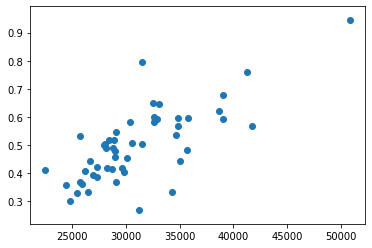

In [139]:
plt.scatter(stateData['IncomePerCap'], stateData['normalized_election_outcome']);

In [140]:
County_merged

,id,county,county_id,state,state_id,DEM_votes,REP_votes,normalized_election_outcome,TotalPop,normalizedMen,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,IncomePerCap,Income,Poverty,ChildPoverty,Unemployment
0,1043,Cullman,43,Alabama,1,4454.0,36804.0,0.107955,81703,0.492308,40223,41480,4.2,92.3,1.1,0.4,0.6,0.0,21857.0,40997,16.4,19.6,5.8
1,1049,DeKalb,49,Alabama,1,4271.0,24744.0,0.147200,71194,0.496222,35328,35866,14.3,80.8,1.4,1.2,0.3,0.1,20020.0,38842,21.5,31.0,5.1
2,1095,Marshall,95,Alabama,1,5880.0,33094.0,0.150870,94738,0.493688,46771,47967,13.3,81.8,2.2,0.5,0.6,0.1,22710.0,41104,21.0,34.1,6.5
3,1103,Morgan,103,Alabama,1,13159.0,39504.0,0.249872,119157,0.493139,58761,60396,8.0,76.4,12.3,0.5,0.7,0.0,25013.0,47529,16.6,24.6,6.5
4,1077,Lauderdale,77,Alabama,1,11872.0,31578.0,0.273234,92590,0.478054,44263,48327,2.5,84.9,9.8,0.4,0.7,0.0,25803.0,44888,16.3,21.9,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,56035,Sublette,35,Wyoming,56,882.0,3957.0,0.182269,10037,0.542692,5447,4590,7.3,89.2,0.0,0.1,0.1,0.0,32175.0,84911,7.4,5.9,4.2
3176,56043,Washakie,43,Wyoming,56,651.0,3245.0,0.167094,8253,0.498970,4118,4135,14.2,82.2,0.3,0.4,0.1,0.0,27345.0,51362,12.8,17.5,6.1
3177,56037,Sweetwater,37,Wyoming,56,3823.0,12229.0,0.238163,44527,0.516114,22981,21546,16.0,79.6,0.8,0.6,0.6,0.5,31700.0,71083,12.0,15.7,5.2
3178,56017,Hot Springs,17,Wyoming,56,482.0,1999.0,0.194277,4741,0.507066,2404,2337,1.9,94.5,0.0,2.3,0.0,0.0,30939.0,48403,12.5,21.2,4.1
